# Angular focus stacking using sensor tilt

## Image-object point relationship when only the sensor is tilted

The general image-object point relationship is given as:

$$
^{i}\acute{{\bf x}} = R_i^T \left( \acute{d}_e \, {\bf r} _{l,3}  - {\bf t}_i \right)  + 
\frac{\left( \hat{{\bf n}}_i (3) \, \acute{z}_o  - \acute{d}_e \, \hat{{\bf n}}_i^T \, {\bf r} _{l,3} \right)}{\hat{{\bf n}}_i^T R_l M_p R_l^T ({\bf x} - d_e\,{\bf r} _{l,3})}
R_i^T R_l M_p R_l^T ({\bf x} - d_e\,{\bf r} _{l,3})  \hspace{25pt} \color{Turquoise}{(1)}
$$


Since only the sensor is tilted about the $x$-axis by $\beta$, we substitute:

* $R_{l} = I$
* $r_{l, 3} = [0, 0, 1]^T = \bar{c}_z$
* $\acute{d}_e = d$
* $d_e = 0$
* $R_i=\begin{bmatrix} 1 & 0 & 0 \\ 0 & cos (\beta) & -sin (\beta) \\ 0 & sin(\beta)  & cos(\beta) \end{bmatrix}$


Substituting into the general equation, we obtain:

$$
^{i}\acute{{\bf x}} = (d  - \acute{z}_o) \, R_i^T \bar{c}_z + 
\frac{(\acute{z}_o  - d) \, cos (\beta)}{\hat{{\bf n}}_i^T M_p {\bf x}}
R_i^T M_p {\bf x} \hspace{25pt} \color{Turquoise}{(2)}
$$


In [1]:
import sympy as sy

In [2]:
sy.init_printing(use_latex='mathjax', print_builtin=False)

In [3]:
beta = sy.symbols('beta', real=True)               # sensor tilt angle
mp = sy.symbols('m_p', real=True, positive=True)   # pupil magnification

In [4]:
Mp = sy.Matrix(((1, 0, 0), 
                (0, 1, 0),
                (0, 0, mp))
              )

In [5]:
Ri = sy.Matrix(((1,       0,              0      ), 
                (0,  sy.cos(beta),  -sy.sin(beta)),
                (0,  sy.sin(beta),   sy.cos(beta)),
                 ))
Ri

⎡1    0        0   ⎤
⎢                  ⎥
⎢0  cos(β)  -sin(β)⎥
⎢                  ⎥
⎣0  sin(β)  cos(β) ⎦

In [6]:
ni = Ri[:,2]
ni

⎡   0   ⎤
⎢       ⎥
⎢-sin(β)⎥
⎢       ⎥
⎣cos(β) ⎦

In [7]:
cz = sy.Matrix(((0),(0),(1)))

In [8]:
Ri*cz  #(ni = Ri*cz)

⎡   0   ⎤
⎢       ⎥
⎢-sin(β)⎥
⎢       ⎥
⎣cos(β) ⎦

In [9]:
x, y, z = sy.symbols('x, y, z', real=True)
X = sy.Matrix(((x), (y), (z)))

X 

⎡x⎤
⎢ ⎥
⎢y⎥
⎢ ⎥
⎣z⎦

In [10]:
Ri.T * Mp * X

⎡           x           ⎤
⎢                       ⎥
⎢m_p⋅z⋅sin(β) + y⋅cos(β)⎥
⎢                       ⎥
⎣m_p⋅z⋅cos(β) - y⋅sin(β)⎦

In [11]:
(ni.T)*Mp*X

[m_p⋅z⋅cos(β) - y⋅sin(β)]

Substituting the above expressions into Eq. (2) we further obtain:

(note that the object coordinates are expressed in the camera coordinate $\{c\}$, but we dropped the superscript that indicate the coordinate frame for simplicity)


$$
^{i}\acute{x} = \frac{(\acute{z}_o - d)\,cos(\beta)}{\left(-y \,sin (\beta) + m_p \, z \, cos(\beta) \right)} x
$$


$$
^{i}\acute{y} =  (d - \acute{z_o})\,sin(\beta) +  \frac{(\acute{z}_o - d)\,cos(\beta)}{\left(-y \,sin (\beta) + m_p \, z \, cos(\beta) \right)} \, \left( y \, cos(\beta) + m_p \, z \, sin(\beta)  \right)
$$


$$
^{i}\acute{z} = 0
$$


Following algebraic simplification, $^{i}\acute{y}$ reduces to:

$$
^{i}\acute{y} =  \frac{(\acute{z}_o - d)}{\left(-y \,sin (\beta) + m_p \, z \, cos(\beta) \right)} y 
$$



We can write the above relationship using homogeneous matrix as:


$$
\left [\begin{array}{c} 
^{i}\acute{x} \\
^{i}\acute{y} \\
w 
\end{array}\right] =
\begin{bmatrix}
(\acute{z}_o -d) \, cos (\beta) & 0 & 0 \\ 
0 & (\acute{z}_o -d) & 0 \\ 
0 & -sin (\beta)  & m_p \, cos(\beta) 
\end{bmatrix}
\left [\begin{array}{c} 
x \\ y \\ z 
\end{array}\right]  \hspace{25pt} \color{Turquoise}{(3)}
$$


The image coordinates in inhomogeneous coordinates is obtained as $^{i}\acute{x} = \frac{^{i}\acute{x}}{w}$ and
$^{i}\acute{y} = \frac{^{i}\acute{y}}{w}$. 


## Image of a grid of points in the object space

In [12]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.colorbar import make_axes
import matplotlib.patches as mpatches
import geometric_model_zemax_commons as gm
import iutils.cv.transforms as cvt
#
# Other useful functions
sind = lambda x : np.sin(np.deg2rad(x))
cosd = lambda x : np.cos(np.deg2rad(x))
tand = lambda x : np.tan(np.deg2rad(x))
arcsind = lambda x : np.rad2deg(np.arcsin(x))
arctand = lambda x : np.rad2deg(np.arctan(x))

In [13]:
%matplotlib inline

In [14]:
def get_image_point(X, beta, zoDash, d, mp):
    """returns geometric image point in inhomogeneous coordinates obtained under
    sensor tilt about the x-axis
    
    Parameters
    ----------
    X : ndarray
        X = [x, y, z]^T
    beta : float
        rotation angle about x-axis
    zoDash : float
        directed distance of the sensor pivot from entrance pupil
    d : float
        directed distance of the exit pupil from the entrance pupil
    mp : float
        pupil magnification
    """
    A = np.array([[(zoDash - d) * cosd(beta),          0       ,           0       ],
                  [           0             ,      (zoDash - d),           0       ],
                  [           0             ,       -sind(beta),      mp*cosd(beta)]])
    XDashHomo = np.dot(A, X)
    return XDashHomo/XDashHomo[2]

In [15]:
#X = np.array([0, 0, -509]).reshape(3, 1)
X = np.array([ [  0,   10 ],
               [  0,    0 ],
               [-509, -519]
              ])
get_image_point(X, 10.0, 20, -5, 1)

array([[-0.        , -0.48169557],
       [-0.        , -0.        ],
       [ 1.        ,  1.        ]])

Plot of the image of two planes obtained using the equation:

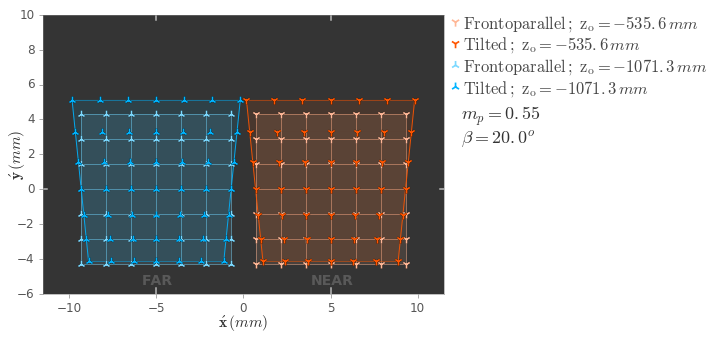

In [16]:
# This is a simplified version of the plot in the notebook 
# "Verification and study of the geometric imaging equations" 
# only for the special case of sensor plane tilt considered in this notebook

beta = 20.0

OPTICAL_SYSTEM = 1

f = 24.0 # focal length
if OPTICAL_SYSTEM == 1: # mp = 0.550000000
    # Optical System 1
    d = -16.8363636
    zoDash = -2.4656319
    mp = 0.55
elif OPTICAL_SYSTEM == 2: # mp = 1.0
    # Optical System 2
    d = -8.0
    zoDash = 17.1707317
    mp = 1.0
else: # mp = 2.0
    # Optical System 3
    d = -20.0
    zoDash = 29.1707317
    mp = 2.0
    

n = 7   # THIS NUMBER SHOULD BE ODD, in order to have the on-axis point (0,0)
nx = np.linspace(-1, 1, n)
hx, hy = np.meshgrid(nx, nx)
yDashNearMax = 4.3  # determines the extent of the image for near plane

# points for the near plane
# -------------------------
zeDash = zoDash - d
ze = -gm.pupil_centric_lens_formula(u=None, v=zeDash, f=f, mp=mp).u
yNearMax = abs(mp*(ze/zeDash)*yDashNearMax)

zNear = ze + 0 # ze = zo - de, where zo is zNear i.e object distance from pivot/coordinate origin

# points @ object plane Z1
XNear = np.vstack((yNearMax*hx.reshape(1, n**2), 
                   yNearMax*hy.reshape(1, n**2), 
                   zNear*np.ones((1, n**2))))


# image points for zero tilts @ object plane Z1
x1 = get_image_point(XNear, 0, zoDash, d ,mp)

# image points for finite tilts @ object plane Z1
x2 = get_image_point(XNear, beta, zoDash, d ,mp)


# points for far plane
# --------------------

# Let the height of the image of the grid of points from the far plane be 
# equal to height of grid of points image from the near plane 

yDashFarMax = abs(x1[0, 0])  # determines the extent of the image for the far plane 

# What should be the object distance, zFar, if the object height is the double
# Since this plane is not in geometrical focus, we can't use the function
# get_image_coordinates(); so we use magnification relationship
yFarMax = 2*yNearMax
mt = -yDashFarMax/yFarMax  # transverse magnification
ze = zeDash/(mp*mt)
zFar = ze + 0 # ze = zo - de where zo is zNear i.e object distance from pivot/coordinate origin

XFar = np.vstack((yFarMax*hx.reshape(1, n**2), 
                  yFarMax*hy.reshape(1, n**2), 
                  zFar*np.ones((1, n**2))))

# image points for zero tilts @ object plane Z2
x3 = get_image_point(XFar, 0, zoDash, d ,mp)

# image points for finite tilts @ object plane Z2
x4 = get_image_point(XFar, beta, zoDash, d ,mp)

# figure
figBGCol = '#343434' 
fig, ax = plt.subplots(1, 1, figsize=(8.45, 5.), dpi=120) 
ax.set_axis_bgcolor(figBGCol)

# Scatter plots' marker colors coding
mcols = ['#FFB796', '#FF5500', '#7CD9FF', '#00B4FF']   # orange and blue

# displace plot for Z1 and Z2
xOffset, yOffset = 5, 0

ax.text(xOffset-1.15, -5.5, 'NEAR', color='#888888', alpha=0.45, fontsize=14, fontweight='bold', zorder=1)

smarker1 = '1'
smarker2 = '2'
ssize1 = 65
ssize2 = 60

# Object plane at Z1

ax.scatter(x1[0, :] + xOffset, x1[1, :] + yOffset, marker=smarker1, s=ssize1, 
           facecolor='k', lw=2.1, alpha=1.0, zorder=13)
ax.scatter(x1[0, :] + xOffset, x1[1, :] + yOffset, marker=smarker1, s=ssize1, 
           facecolor=mcols[0], lw=1.7, alpha=1.0, zorder=13,
           label=r'$\rm{{Frontoparallel}} \,;\,\,  z_o={{{:.1f}}}\, \it{{mm}}$'.format(zNear))


# shade region to show the span of the grid of points
for i in range(n-1):
    plt.fill_between(x=x1[0, i*n:(i+1)*n] + xOffset, 
                     y1=x1[1, i*n:(i+1)*n] + yOffset, 
                     y2=x1[1, (i+1)*n:(i+2)*n] + yOffset, 
                     alpha=0.1, facecolor=mcols[0], edgecolor='none', zorder=2)

# grid to show the undistorted shape of points
xGridPts = x1[0, :][:n] + xOffset
yGridPts = x1[1, :][::n] + yOffset
ax.vlines(xGridPts, ymin=min(yGridPts), ymax=max(yGridPts), zorder=2, colors=mcols[0], 
          lw=0.8, alpha=0.6)
ax.hlines(yGridPts, xmin=min(xGridPts), xmax=max(xGridPts), zorder=2, colors=mcols[0], 
          lw=0.8, alpha=0.6)

# finite tilt
ax.scatter(x2[0, :] + xOffset, x2[1, :] + yOffset, 
           marker=smarker1, s=ssize1, facecolor='k', lw=2.1, alpha=1.0, zorder=13, clip_on=False)
ax.scatter(x2[0, :] + xOffset, x2[1, :] + yOffset, 
           marker=smarker1, s=ssize1, facecolor=mcols[1], lw=1.7, alpha=1.0, zorder=13, clip_on=False, 
           label=r'$\rm{{Tilted}} \,;\,\, z_o={{{:.1f}}}\, \it{{mm}}$'.format(zNear))


# shade region to show the span of the grid of points
for i in range(n-1):
    x_row1 = x2[0, i*n:(i+1)*n] + xOffset
    x_row2 = x2[0, (i+1)*n:(i+2)*n] + xOffset
    y_row1 = x2[1, i*n:(i+1)*n] + yOffset
    y_row2 = x2[1, (i+1)*n:(i+2)*n] + yOffset
    # we need to reverse the order of points from the second row
    # so that the order of points (at the transition between rows) 
    # is circular and not zig-zag
    x_pts = np.concatenate((x_row1, x_row2[::-1]))
    y_pts = np.concatenate((y_row1, y_row2[::-1]))
    k = np.hstack((x_pts[:, np.newaxis], y_pts[:, np.newaxis]))
    patch = mpatches.Polygon(xy=k, closed=True, facecolor=mcols[1], 
                             edgecolor='none', alpha=0.1, zorder=3, clip_on=False)
    ax.add_patch(patch)

# draw outer boundery
ax.plot(x2[0, :n] + xOffset, x2[1, :n], color=mcols[1], 
        lw=0.9, zorder=2, alpha=0.5, clip_on=False) # top
ax.plot(x2[0, -n::] + xOffset, x2[1, -n::], color=mcols[1], 
        lw=0.9, zorder=2, alpha=0.5,  clip_on=False) # bottom
ax.plot(x2[0, n-1::n] + xOffset, x2[1, n-1::n], color=mcols[1], 
        lw=1.0, zorder=2, alpha=0.9,  clip_on=False) # left side
ax.plot(x2[0, ::n] + xOffset, x2[1, ::n], color=mcols[1], 
        lw=1.0, zorder=2, alpha=0.9,  clip_on=False) # right side


# Object plane at Z2
xOffset, yOffset = -5, 0

ax.text(xOffset-0.8, -5.5, 'FAR', color='#888888', alpha=0.45, fontsize=14, fontweight='bold', zorder=1)

ax.scatter(x3[0, :] + xOffset, x3[1, :] + yOffset, marker=smarker2, s=ssize2, 
           color='k', lw=2.1, alpha=1.0, zorder=12)
ax.scatter(x3[0, :] + xOffset, x3[1, :] + yOffset, marker=smarker2, s=ssize2, 
           color=mcols[2], lw=1.7, alpha=1.0, zorder=12,
           label=r'$\rm{{Frontoparallel}} \,;\, \, z_o={{{:.1f}}}\,\it{{mm}}$'.format(zFar))

# shade region to show the span of the grid of points
for i in range(n-1):
    plt.fill_between(x=x3[0, i*n:(i+1)*n] + xOffset, 
                     y1=x3[1, i*n:(i+1)*n] + yOffset, 
                     y2=x3[1, (i+1)*n:(i+2)*n] + yOffset, 
                     alpha=0.1, facecolor=mcols[2], edgecolor='none', zorder=2)

# grid to show the undistorted shape of points
xGridPts = x3[0, :][:n] + xOffset
yGridPts = x3[1, :][::n] + yOffset
ax.vlines(xGridPts, ymin=min(yGridPts), ymax=max(yGridPts), zorder=2, colors=mcols[2], 
          lw=0.8, alpha=0.6)
ax.hlines(yGridPts, xmin=min(xGridPts), xmax=max(xGridPts), zorder=2, colors=mcols[2], 
          lw=0.8, alpha=0.6)

# finite tilts
ax.scatter(x4[0, :] + xOffset, x4[1, :] + yOffset, 
           marker=smarker2, s=ssize2, color='k', lw=2.1, alpha=1.0, clip_on=False, zorder=12,)
ax.scatter(x4[0, :] + xOffset, x4[1, :] + yOffset, 
           marker=smarker2, s=ssize2, color=mcols[3], lw=1.7, alpha=1.0, clip_on=False, zorder=12, 
           label=r'$\rm{{Tilted}} \,;\,\, z_o={{{:.1f}}}\, \it{{mm}}$'.format(zFar))

# shade region to show the span of the grid of points
for i in range(n-1):
    x_row1 = x4[0, i*n:(i+1)*n] + xOffset
    x_row2 = x4[0, (i+1)*n:(i+2)*n] + xOffset
    y_row1 = x4[1, i*n:(i+1)*n] + yOffset
    y_row2 = x4[1, (i+1)*n:(i+2)*n] + yOffset
    # we need to reverse the order of points from the second row
    # so that the order of points (at the transition between rows) 
    # is circular and not zig-zag
    x_pts = np.concatenate((x_row1, x_row2[::-1]))
    y_pts = np.concatenate((y_row1, y_row2[::-1]))
    k = np.hstack((x_pts[:, np.newaxis], y_pts[:, np.newaxis]))
    patch = mpatches.Polygon(xy=k, closed=True, facecolor=mcols[3], 
                             edgecolor='none', alpha=0.1, zorder=3, clip_on=False)
    ax.add_patch(patch)

# draw outer boundery
ax.plot(x4[0, :n] + xOffset, x4[1, :n], color=mcols[3], 
        lw=0.9, alpha=0.5, clip_on=False, zorder=2) # top
ax.plot(x4[0, -n::] + xOffset, x4[1, -n::], color=mcols[3], 
        lw=0.9, alpha=0.5, clip_on=False, zorder=2) # bottom
ax.plot(x4[0, n-1::n] + xOffset, x4[1, n-1::n], color=mcols[3], 
        clip_on=False, alpha=0.9, lw=1.0, zorder=2) # left side
ax.plot(x4[0, ::n] + xOffset, x4[1, ::n], color=mcols[3], 
        lw=1.0, alpha=0.9, clip_on=False, zorder=2) # right side

#
ax.set_xlim(-11.5, 11.5)
ax.set_ylim(-6, 10)
ax.set_aspect('equal')

ax.set_ylabel(r'$\'{\bf{y}} \,\it{(mm)}$', fontsize=15.5, color='#333333', labelpad=-10)
ax.set_xlabel(r'$\'{\bf{x}} \,\it{(mm)}$', fontsize=15.5, color='#333333', labelpad=-2)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# draw center markers
ctrMCol = '#BBBBBB'
ax.axvline(x=xOffset, ymin=0, ymax=0.02, lw=1.5, color=ctrMCol)
ax.axvline(x=-xOffset, ymin=0, ymax=0.02, lw=1.5, color=ctrMCol)
ax.axvline(x=xOffset, ymin=0.98, ymax=1, lw=1.5, color=ctrMCol)
ax.axvline(x=-xOffset, ymin=0.98, ymax=1, lw=1.5, color=ctrMCol)

ax.axhline(y=yOffset, xmin=0, xmax=0.01, lw=1.5, color=ctrMCol)
ax.axhline(y=yOffset, xmin=0.99, xmax=1, lw=1.5, color=ctrMCol)


txt1 = r'$m_p ={}$'.format(mp)
txt2 = r'$\beta ={}^o$'.format(beta) 
# at top right (outside the axes)
txtOff = -0.32  
fig.text(0.87, 0.93 + txtOff, txt1, fontsize=18, color='#333333')
fig.text(0.87, 0.86 + txtOff, txt2, fontsize=18, color='#333333')

# Legend and other information
ax.legend(fontsize=16.5, scatterpoints=1, markerscale=1.12, scatteryoffsets=[0.5],
          ncol=1, loc='upper right', bbox_to_anchor=(1.3, 0.945), labelspacing=0.1,
          bbox_transform=fig.transFigure, handletextpad=0.38, handlelength=0.2)


plt.show()

## Inter-image homography

The relationship been the image and object coordinates under sensor (only) tilt (about the x-axis by $\beta$) is given as:

$$
\left [\begin{array}{c} 
^{i}\acute{x} \\
^{i}\acute{y} \\
w 
\end{array}\right] =
\underbrace{
\begin{bmatrix}
(\acute{z}_o -d) \, cos (\beta) & 0 & 0 \\ 
0 & (\acute{z}_o -d) & 0 \\ 
0 & -sin (\beta)  & m_p \, cos(\beta) 
\end{bmatrix}
}_{A(\beta)}
\left [\begin{array}{c} 
x \\ y \\ z 
\end{array}\right]  \hspace{25pt} \color{Turquoise}{(3)}
$$

Let's represent the image-object relationship under two different orientations of the sensor tilts as follows:


$$
\begin{array}{cc}
^{i}\acute{{\bf x}}_1 & = & A(\beta_1) \, \bf x \\
^{i}\acute{{\bf x}}_2 & = & A(\beta_2) \, \bf x
\end{array}  \hspace{25pt} \color{Turquoise}{(4)}
$$  

Then, the inter-image homography can be obtained as:

$$
^{i}\acute{{\bf x}}_2 = \underbrace{A(\beta_2) \, A(\beta_1)^{-1}}_{H(\beta_2, \, \beta_1)} \, ^{i}\acute{{\bf x}}_1 \hspace{25pt} \color{Turquoise}{(5)} 
$$

In [17]:
beta1 = sy.symbols('beta_1', real=True)           # sensor tilt angle
beta2 = sy.symbols('beta_2', real=True)           # sensor tilt angle
mp = sy.symbols('m_p', real=True, positive=True)  # pupil magnification
d = sy.symbols('d', real=True)                    # directed distance of the exit-pupil from the entrance pupil
zoDash = sy.symbols("z'_o", real=True)            # directed distance of the image-plane pivot from entrance pupil

A1 = sy.Matrix((( (zoDash -d)*sy.cos(beta1),         0    ,            0      ), 
                (        0,                    (zoDash -d),            0      ),
                (        0,                 -sy.sin(beta1),   mp*sy.cos(beta1)),
                ))

A2 = sy.Matrix((( (zoDash -d)*sy.cos(beta2),         0    ,            0      ), 
                (        0,                    (zoDash -d),            0      ),
                (        0,                 -sy.sin(beta2),   mp*sy.cos(beta2)),
                ))

In [18]:
A1

⎡(-d + z'ₒ)⋅cos(β₁)     0           0     ⎤
⎢                                         ⎥
⎢        0           -d + z'ₒ       0     ⎥
⎢                                         ⎥
⎣        0           -sin(β₁)  m_p⋅cos(β₁)⎦

In [19]:
A2

⎡(-d + z'ₒ)⋅cos(β₂)     0           0     ⎤
⎢                                         ⎥
⎢        0           -d + z'ₒ       0     ⎥
⎢                                         ⎥
⎣        0           -sin(β₂)  m_p⋅cos(β₂)⎦

In [20]:
H = A2*A1.inv()
H

⎡cos(β₂)                                        ⎤
⎢───────                0                   0   ⎥
⎢cos(β₁)                                        ⎥
⎢                                               ⎥
⎢   0                   1                   0   ⎥
⎢                                               ⎥
⎢          sin(β₁)⋅cos(β₂)     sin(β₂)   cos(β₂)⎥
⎢   0     ────────────────── - ────────  ───────⎥
⎣         (-d + z'ₒ)⋅cos(β₁)   -d + z'ₒ  cos(β₁)⎦

In [21]:
H.simplify()
H

⎡cos(β₂)                            ⎤
⎢───────          0             0   ⎥
⎢cos(β₁)                            ⎥
⎢                                   ⎥
⎢   0             1             0   ⎥
⎢                                   ⎥
⎢           -sin(β₁ - β₂)    cos(β₂)⎥
⎢   0     ─────────────────  ───────⎥
⎣         (d - z'ₒ)⋅cos(β₁)  cos(β₁)⎦

The inter-image homography, in physical units, is represented as:

$$
H(\beta_2, \, \beta_1) = 
\left[\begin{matrix}\frac{\cos{\left (\beta_{2} \right )}}{\cos{\left (\beta_{1} \right )}} & 0 & 0\\0 & 1 & 0\\0 & \frac{\sin{\left (\beta_{1} - \beta_{2} \right )}}{\left(z'_{o} - d\right) \cos{\left (\beta_{1} \right )}} & \frac{\cos{\left (\beta_{2} \right )}}{\cos{\left (\beta_{1} \right )}}\end{matrix}\right]
$$

Note that the diagonal components of the above inter-image homography are unitless. The element in the third row and second column has the unit of $1/mm$ (inverse of the physical dimension). Therefore, if $p$ is the pixel pitch in $mm$, then, the inter-image homography is obtained as:


$$
H(\beta_2, \, \beta_1) = 
\left[\begin{matrix}\frac{\cos{\left (\beta_{2} \right )}}{\cos{\left (\beta_{1} \right )}} & 0 & 0\\0 & 1 & 0\\0 & \frac{\sin{\left (\beta_{1} - \beta_{2} \right )}}{p \, \left(z'_{o} - d\right) \cos{\left (\beta_{1} \right )}} & \frac{\cos{\left (\beta_{2} \right )}}{\cos{\left (\beta_{1} \right )}}\end{matrix}\right]
$$


Furthermore, if $\beta_1 = 0$, then the inter image homography is given as:


$$
H(\beta_2, 0) = 
\begin{bmatrix} 
cos (\beta_2) & 0 & 0 \\ 
0 & 1 & 0 \\ 
0 & \frac{-sin(\beta_2)}{p \, (z'_o - d)}  & cos(\beta_2) 
\end{bmatrix}
$$

### Verification of the inter-image homography expression

The basic idea for this verification is that $x_2 = H(\beta_2, 0) \, x_1$,  where $x_1$ is the image obtained when the sensor is untilted, and $x_2$ is the image obtained when the sensor is tilted about the x-axis by $\beta_2$.

Sence we have both the set of points--$x_2$ and $x_1$--from the above plot example, we can verify if the estimate $\hat{x}_2$ obtained $H(\beta_2, 0) \, x_1$ equals $x_2$. 

Also, note that $H(\beta_2, 0) \, x_1$ gives $\hat{x}_2$ in homogeneous coordinates. To convert to inhomogeneous coordinates, we have to divide by the thrid element for each coordinate.

In [22]:
beta1 = 0.0
beta2 = 20.0


OPTICAL_SYSTEM = 1

f = 24.0 # focal length
if OPTICAL_SYSTEM == 1: # mp = 0.550000000
    # Optical System 1
    d = -16.8363636
    zoDash = -2.4656319
    mp = 0.55
elif OPTICAL_SYSTEM == 2: # mp = 1.0
    # Optical System 2
    d = -8.0
    zoDash = 17.1707317
    mp = 1.0
else: # mp = 2.0
    # Optical System 3
    d = -20.0
    zoDash = 29.1707317
    mp = 2.0
    

n = 5   # THIS NUMBER SHOULD BE ODD, in order to have the on-axis point (0,0)
nx = np.linspace(-1, 1, n)
hx, hy = np.meshgrid(nx, nx)
yDashNearMax = 4.3  # determines the extent of the image for near plane

# points for a plane
# ------------------
zeDash = zoDash - d
ze = -gm.pupil_centric_lens_formula(u=None, v=zeDash, f=f, mp=mp).u
yNearMax = abs(mp*(ze/zeDash)*yDashNearMax)

zNear = ze + 0 # ze = zo - de, where zo is zNear i.e object distance from pivot/coordinate origin

# points @ object plane Z1
XNear = np.vstack((yNearMax*hx.reshape(1, n**2), 
                   yNearMax*hy.reshape(1, n**2), 
                   zNear*np.ones((1, n**2))))


# image points for zero tilts @ object plane Z1
x1 = get_image_point(XNear, beta1, zoDash, d, mp)

# image points for finite tilts @ object plane Z1
x2 = get_image_point(XNear, beta2, zoDash, d, mp)


# Homography H(beta2, beta1)

p = 1 # pixel size
H = np.array([[cosd(beta2),                  0                 ,      0      ],
              [       0      ,               1                 ,      0      ],
              [       0      ,  -sind(beta2)/(p*(zoDash - d))  ,  cosd(beta2)]])

In [23]:
XNear

array([[ -88.15000055,  -44.07500028,    0.        ,   44.07500028,
          88.15000055,  -88.15000055,  -44.07500028,    0.        ,
          44.07500028,   88.15000055,  -88.15000055,  -44.07500028,
           0.        ,   44.07500028,   88.15000055,  -88.15000055,
         -44.07500028,    0.        ,   44.07500028,   88.15000055,
         -88.15000055,  -44.07500028,    0.        ,   44.07500028,
          88.15000055],
       [ -88.15000055,  -88.15000055,  -88.15000055,  -88.15000055,
         -88.15000055,  -44.07500028,  -44.07500028,  -44.07500028,
         -44.07500028,  -44.07500028,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,   44.07500028,
          44.07500028,   44.07500028,   44.07500028,   44.07500028,
          88.15000055,   88.15000055,   88.15000055,   88.15000055,
          88.15000055],
       [-535.63636671, -535.63636671, -535.63636671, -535.63636671,
        -535.63636671, -535.63636671, -535.63636671, -535.63636671,


In [24]:
x1

array([[ 4.3 ,  2.15, -0.  , -2.15, -4.3 ,  4.3 ,  2.15, -0.  , -2.15,
        -4.3 ,  4.3 ,  2.15, -0.  , -2.15, -4.3 ,  4.3 ,  2.15, -0.  ,
        -2.15, -4.3 ,  4.3 ,  2.15, -0.  , -2.15, -4.3 ],
       [ 4.3 ,  4.3 ,  4.3 ,  4.3 ,  4.3 ,  2.15,  2.15,  2.15,  2.15,
         2.15, -0.  , -0.  , -0.  , -0.  , -0.  , -2.15, -2.15, -2.15,
        -2.15, -2.15, -4.3 , -4.3 , -4.3 , -4.3 , -4.3 ],
       [ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
         1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
         1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ]])

In [25]:
x2

array([[ 4.82553401,  2.412767  , -0.        , -2.412767  , -4.82553401,
         4.54763441,  2.2738172 , -0.        , -2.2738172 , -4.54763441,
         4.3       ,  2.15      , -0.        , -2.15      , -4.3       ,
         4.07794197,  2.03897098, -0.        , -2.03897098, -4.07794197,
         3.87769249,  1.93884624, -0.        , -1.93884624, -3.87769249],
       [ 5.13522603,  5.13522603,  5.13522603,  5.13522603,  5.13522603,
         2.41974573,  2.41974573,  2.41974573,  2.41974573,  2.41974573,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -2.1698276 , -2.1698276 , -2.1698276 , -2.1698276 , -2.1698276 ,
        -4.12655415, -4.12655415, -4.12655415, -4.12655415, -4.12655415],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1

In [26]:
H

array([[ 0.93969262,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.        , -0.02379977,  0.93969262]])

In [27]:
print(x1.shape)
print(H.shape)

(3L, 25L)
(3L, 3L)


In [28]:
x2_est_h = np.dot(H, x1)
x2_est_h 

array([[ 4.04067827,  2.02033913,  0.        , -2.02033913, -4.04067827,
         4.04067827,  2.02033913,  0.        , -2.02033913, -4.04067827,
         4.04067827,  2.02033913,  0.        , -2.02033913, -4.04067827,
         4.04067827,  2.02033913,  0.        , -2.02033913, -4.04067827,
         4.04067827,  2.02033913,  0.        , -2.02033913, -4.04067827],
       [ 4.3       ,  4.3       ,  4.3       ,  4.3       ,  4.3       ,
         2.15      ,  2.15      ,  2.15      ,  2.15      ,  2.15      ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -2.15      , -2.15      , -2.15      , -2.15      , -2.15      ,
        -4.3       , -4.3       , -4.3       , -4.3       , -4.3       ],
       [ 0.8373536 ,  0.8373536 ,  0.8373536 ,  0.8373536 ,  0.8373536 ,
         0.88852311,  0.88852311,  0.88852311,  0.88852311,  0.88852311,
         0.93969262,  0.93969262,  0.93969262,  0.93969262,  0.93969262,
         0.99086213,  0.99086213,  0.99086213,  0

In [29]:
x2_est_h/x2_est_h[2] - x2

array([[  8.88178420e-16,   4.44089210e-16,   0.00000000e+00,
         -4.44089210e-16,  -8.88178420e-16,   8.88178420e-16,
          4.44089210e-16,   0.00000000e+00,  -4.44089210e-16,
         -8.88178420e-16,   8.88178420e-16,   4.44089210e-16,
          0.00000000e+00,  -4.44089210e-16,  -8.88178420e-16,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   8.88178420e-16,
          4.44089210e-16,   0.00000000e+00,  -4.44089210e-16,
         -8.88178420e-16],
       [  8.88178420e-16,   8.88178420e-16,   8.88178420e-16,
          8.88178420e-16,   8.88178420e-16,   4.44089210e-16,
          4.44089210e-16,   4.44089210e-16,   4.44089210e-16,
          4.44089210e-16,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,  -8.88178420e-16,
         -8.88178420e-16,  -8.88178420e-16,

Given X1 and X2 what is the homography returned by OpenCV's `get_homography2D()` function?

In [30]:
H_est_DLT = cvt.get_homography2D(fp=x1, tp=x2)
H_est_DLT

array([[  1.00000000e+00,   4.00641641e-16,  -9.68046243e-16],
       [ -5.27449667e-17,   1.06417777e+00,  -3.35594010e-16],
       [ -3.68732582e-17,  -2.53271888e-02,   1.00000000e+00]])

In [31]:
Hnew = H/H[2,2]
Hnew

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  1.06417777,  0.        ],
       [ 0.        , -0.02532719,  1.        ]])

In [32]:
x2_est_new = np.dot(Hnew, x1)

In [33]:
x2_est_new/x2_est_new[2] - x2

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   4.44089210e-16,
          2.22044605e-16,   0.00000000e+00,  -2.22044605e-16,
         -4.44089210e-16],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   4.44089210e-16,
          4.44089210e-16,   4.44089210e-16,   4.44089210e-16,
          4.44089210e-16,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,  -8.88178420e-16,
         -8.88178420e-16,  -8.88178420e-16,

The above experiment implies that the homographies H and H/H[2,2] are equivalent!

### Determination of image plane distance and angles

In [34]:
def get_zoDash(zo, deDash, de=0, mp=1.0, f=180.0):
    """return the image plane pivot distance from the origin of {C}
    """
    return deDash + (mp**2 * f * (zo - de)) / (mp * (zo - de) + f)

def get_beta(theta, zo, zoDash, deDash, de=0, mp=1):
    """return the image plane tilt angle 
    
    Parameters
    ----------
    theta : float
        object plane tilt angle
    zo : float
        object plane distance from origin of {C}
    zoDash : float
        image plane distance from origin of {C}
    deDash : float
    de : float
    mp : float
    
    Returns
    -------
    beta : float
        image plane tilt angle
    """
    tanBeta = ((zoDash - deDash) / (mp * (zo - de))) * tand(theta)
    return arctand(tanBeta)
    

def get_theta(beta, zo, zoDash, deDash, de=0, mp=1):
    """return the image plane tilt angle 
    
    Parameters
    ----------
    beta : float
        sensor plane tilt angle
    zo : float
        object plane distance from origin of {C}
    zoDash : float
        image plane distance from origin of {C}
    deDash : float
    de : float
    mp : float
    
    Returns
    -------
    theta : float
        object plane tilt angle
    """
    tanTheta = ((mp * (zo - de)) / (zoDash - deDash) ) * tand(beta)
    return arctand(tanTheta)

Fronto-parallel focus on the front plane

In [35]:
zoDash = get_zoDash(zo=-2641.6, deDash=-7)
zoDash

186.16217094572636

In [36]:
beta = get_beta(theta=-60.0, zo=-2641.6, zoDash=zoDash, deDash=-7)
beta

7.218252908210979

In [37]:
beta = get_beta(theta=-78.5, zo=-2641.6, zoDash=zoDash, deDash=-7)
beta

19.769039658371433

Fronto-parallel focus on the middle plane

In [38]:
zoDash = get_zoDash(zo=-3416.3, deDash=-7)
zoDash

183.0114328090721

In [39]:
theta = get_theta(beta=-15, zo=-3416.3, zoDash=zoDash, deDash=-7)
theta

78.273458193862751

In [40]:
30*tand(22)

12.120786775054704

In [41]:
zoDash = get_zoDash(zo=-4191, deDash=-7)
zoDash

181.07778608825728

In [42]:
theta = get_theta(beta=-15, zo=-4191, zoDash=zoDash, deDash=-7)
theta

80.492247294618195

## Registration and blending of images

In [43]:
from __future__ import print_function, division
import os
import gc
import cv2
import numpy as np
import iutils.image.general as ig
from scipy.misc import imread, imsave
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import iutils.cv.transforms as cvt
#from IPython.display import display
#from ipywidgets import interactive


sind = lambda x : np.sin(np.deg2rad(x))
cosd = lambda x : np.cos(np.deg2rad(x))
tand = lambda x : np.tan(np.deg2rad(x))
arcsind = lambda x : np.rad2deg(np.arcsin(x))
arctand = lambda x : np.rad2deg(np.arctan(x))

In [44]:
%matplotlib inline

In [50]:
# Inter-image homography

def get_inter_image_homography(beta2, beta1, p, d, zoDash, xo, yo):
    """returns the inter-image homography matrix H(beta2, beta1) 
    
    I2 = H(beta2, beta1) I1
    
    """
    A = np.array([[cosd(beta2)/cosd(beta1),               0                 ,                       0           ],
                  [       0      ,                        1                 ,                       0           ],
                  [       0      ,  sind(beta1 - beta2)/((zoDash - d)*cosd(beta1))  ,  cosd(beta2)/cosd(beta2)]])
    
    K = np.array([[-1/px,    0  ,   xo],
                  [  0  ,  -1/py,   yo],
                  [  0  ,    0,     1]])
    Kinv = np.linalg.inv(K)
    H = np.dot( K  , np.dot(A, Kinv))
    
    return H

In [46]:
# Image information
# 002: + 19°   
# 003: + 15°
# 004: + 10°
# 006: - 10°

px = py = 0.006
xo = 4182//2
yo = 4772//2
p = 0.006
d = -7.0
zoDash = 181.0


unregisteredImgNames = ['bild002.png', 'bild003.png', 'bild004.png', 'bild006.png']
sensorRotationAngles = [19.0, 15.0, 10.0, -10.0]
unregisteredImgDir = "C:\\thesis_images\\2016-12-10\\unregistered_images"
registeredImgDir = "C:\\thesis_images\\2016-12-10\\registered_images"

In [51]:
for uri, beta in zip(unregisteredImgNames, sensorRotationAngles):
    unRegImg = imread(os.path.join(unregisteredImgDir, uri))
    rows, cols, _ = unRegImg.shape
    H = get_inter_image_homography(beta, 0, p, d, zoDash, xo, yo)
    H = H/H[2,2]
    print('beta =', beta)
    print('H =\n', H)
    print('\n')
    regImg = cv2.warpPerspective(unRegImg, H, (cols, rows))
    imsave(os.path.join(registeredImgDir, uri), regImg)

beta = 19.0
H =
 [[  9.22644675e-01  -2.12008740e-02  -1.61749985e+02]
 [  0.00000000e+00   9.51616178e-01  -5.77218991e+01]
 [  0.00000000e+00   1.01391076e-05   1.00000000e+00]]


beta = 15.0
H =
 [[  9.47256541e-01  -1.69382095e-02  -1.10286572e+02]
 [  0.00000000e+00   9.61344268e-01  -4.61162883e+01]
 [  0.00000000e+00   8.10053059e-06   1.00000000e+00]]


beta = 10.0
H =
 [[  9.71955465e-01  -1.14370119e-02  -5.86411219e+01]
 [  0.00000000e+00   9.73898890e-01  -3.11386240e+01]
 [  0.00000000e+00   5.46963742e-06   1.00000000e+00]]


beta = -10.0
H =
 [[  9.98004490e-01   1.17435310e-02  -4.17261113e+00]
 [  0.00000000e+00   1.02680064e+00   3.19731589e+01]
 [  0.00000000e+00  -5.61622719e-06   1.00000000e+00]]


